In [1]:
%load_ext autoreload
%autoreload 2

import os
import re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from utils import *
import matplotlib
set_mpl_params()

#### Conversion factors

In [2]:
Ry = 13.605693122990 # eV
Bohr = 0.529177210544 # Angstrom
angstrom = 1e-10  # meter 
eV = 1.602176634e-19  # Joule

#### Problem 1 (10 pts): convergence of total (absolute) energies w.r.t cutoff energies
- 2 Atoms per unit cell
- Threshold at $5$ meV/atom
- Energy per atom = total energy / 2
- Cutoff energies are [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 1000] Ry

In [3]:
filepath = "Problem1/bulk_energy_vs_kinetic_energy_cutoff.dat"
df = pd.read_csv(filepath, header=None, names=["E [Ry]"]) / 2
df["E_cutoff [Ry]"] = (df.index + 1) * 10
df.loc[df.index[-1], "E_cutoff [Ry]"] = 1000

df["E [eV]"] = df["E [Ry]"] * Ry 
df["E_cutoff [eV]"] = df["E_cutoff [Ry]"] * Ry

last_Ry = df["E [Ry]"].iloc[-1]
last_eV = df["E [eV]"].iloc[-1]

# Check for convergence
energy_threshold = 5e-3  # meV/atom
df["Convergence [Ry]"] = np.abs(df["E [Ry]"] - last_Ry)
df["Convergence [eV]"] = np.abs(df["E [eV]"] - last_eV)
df["Converged"] = df["Convergence [eV]"] < energy_threshold
df.head(10)

,E [Ry],E_cutoff [Ry],E [eV],E_cutoff [eV],Convergence [Ry],Convergence [eV],Converged
0,-52.237827,10,-710.731837,136.056931,3.148739,42.840771,False
1,-54.466036,20,-741.048167,272.113862,0.920529,12.524441,False
2,-55.078958,30,-749.387403,408.170794,0.307607,4.185206,False
3,-55.291425,40,-752.278159,544.227725,0.095140,1.294449,False
4,-55.362740,50,-753.248452,680.284656,0.023825,0.324156,False
5,-55.382010,60,-753.510638,816.341587,0.004555,0.061970,False
6,-55.386002,70,-753.564950,952.398519,0.000563,0.007658,False
7,-55.386508,80,-753.571826,1088.455450,0.000057,0.000782,True
8,-55.386542,90,-753.572296,1224.512381,0.000023,0.000312,True
9,-55.386545,100,-753.572334,1360.569312,0.000020,0.000274,True


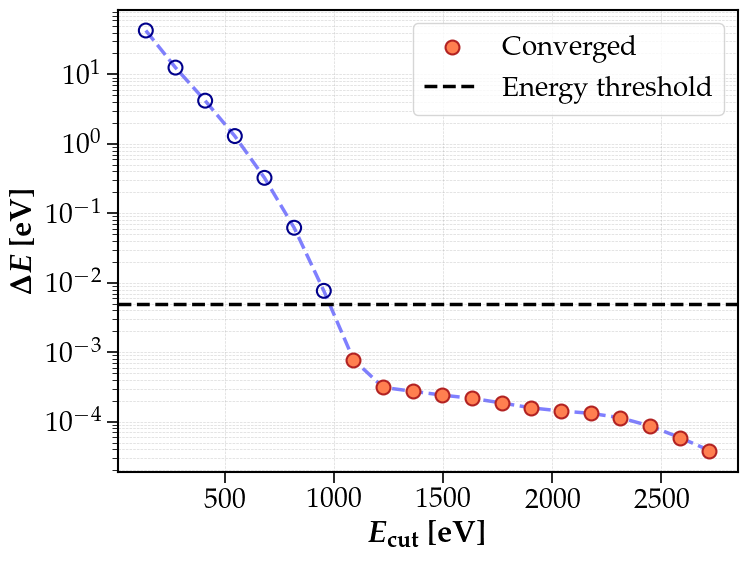

In [4]:
plt.plot(df["E_cutoff [eV]"][:-1], df["Convergence [eV]"][:-1], color="blue", linestyle="--", alpha=0.5, zorder=1)

# Scatter non converged points
plt.scatter(df[~df["Converged"]]["E_cutoff [eV]"], df[~df["Converged"]]["Convergence [eV]"], 
            marker="o", color="None", edgecolor="darkblue", s=100, linewidths=1.5, zorder=2)

# Scatter converged points
plt.scatter(df[df["Converged"]]["E_cutoff [eV]"][:-1], df[df["Converged"]]["Convergence [eV]"][:-1], 
            marker="o", color="coral", edgecolors="firebrick", linewidths=1.5, label="Converged", zorder=2)

plt.axhline(energy_threshold, color='black', linestyle='--', label="Energy threshold")
plt.xlabel(r"$\boldsymbol{E_{\rm cut}}$ $\textbf{[eV]}$")
plt.ylabel(r"$\boldsymbol{\Delta E}$ $\textbf{[eV]}$")
plt.yscale("log")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.3)

FIG_PATH = "Figures/"
os.makedirs(FIG_PATH, exist_ok=True)
figname = "P1_bulk_energy_vs_kinetic_energy_cutoff.pdf" 
plt.savefig(os.path.join(FIG_PATH, figname), bbox_inches="tight")

plt.show()

#### Problem 2 (10 pts): convergence of forces w.r.t cutoff energies

- **Ca** atom moved by +0.05 in the $z$ direction
- Force convergence threshold of 10 meV/$\text{\AA}$ 
- Cutoff energies are [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 1000] Ry

In [5]:
filename = "Problem2/simulations/forces.dat"
data = []

data.extend(extract_forces(filename))
columns = ['E_cut [Ry]', 'Atom', 'Type', 'f_x', 'f_y', 'f_z [Ry/Bohr]']
df = pd.DataFrame(data, columns=columns).sort_values(by=['E_cut [Ry]', 'Atom']).drop(columns=['f_x', 'f_y']).reset_index()  # drop f_x, f_y since they are always zero
df['f_z [eV/Ang]'] = df['f_z [Ry/Bohr]'] * Ry / Bohr
df["E_cut [eV]"] = df["E_cut [Ry]"] * Ry

df_atom_1 = df[df["Atom"] == 1].copy()
df_atom_2 = df[df["Atom"] == 2].copy()

In [6]:
force_threshold = 10e-3 # eV/Angstrom

last_f_atom_1 = df_atom_1["f_z [eV/Ang]"].iloc[-1]
last_f_atom_2 = df_atom_2["f_z [eV/Ang]"].iloc[-1]

In [7]:
df_atom_1["Convergence"] = np.abs(df_atom_1["f_z [eV/Ang]"] - last_f_atom_1)
df_atom_2["Convergence"] = np.abs(df_atom_2["f_z [eV/Ang]"] - last_f_atom_2)
df_atom_1["Converged"] = df_atom_1["Convergence"] < force_threshold
df_atom_2["Converged"] = df_atom_2["Convergence"] < force_threshold

df_atom_1.head(10)

,index,E_cut [Ry],Atom,Type,f_z [Ry/Bohr],f_z [eV/Ang],E_cut [eV],Convergence,Converged
0,0,10.0,1,1,-0.150135,-3.860138,136.056931,2.751733,False
2,24,20.0,1,1,-0.093613,-2.406879,272.113862,1.298474,False
4,28,30.0,1,1,-0.035322,-0.908156,408.170794,0.200248,False
6,30,40.0,1,1,-0.045319,-1.165196,544.227725,0.056792,False
8,32,50.0,1,1,-0.042895,-1.102862,680.284656,0.005542,True
10,34,60.0,1,1,-0.043204,-1.110816,816.341587,0.002412,True
12,36,70.0,1,1,-0.043128,-1.108855,952.398519,0.000450,True
14,38,80.0,1,1,-0.043135,-1.109053,1088.455450,0.000648,True
16,40,90.0,1,1,-0.043148,-1.109376,1224.512381,0.000972,True
18,2,100.0,1,1,-0.043149,-1.109410,1360.569312,0.001006,True


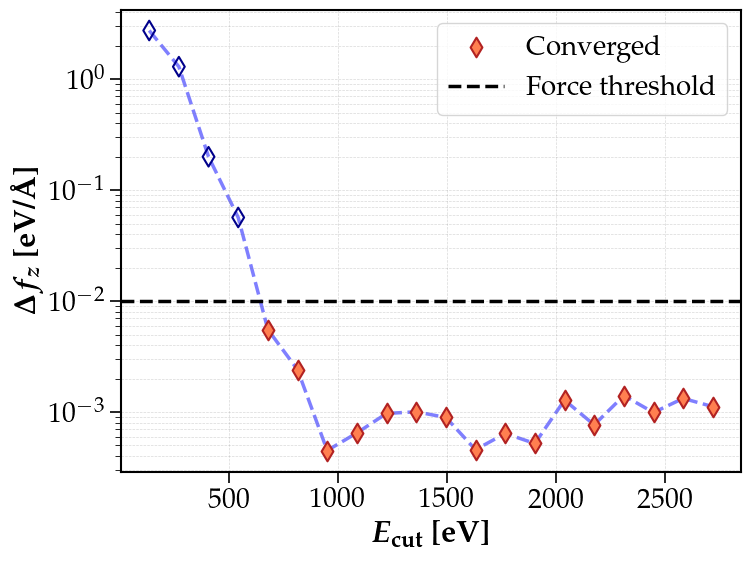

In [8]:
plt.plot(df_atom_1["E_cut [eV]"][:-1], df_atom_1["Convergence"][:-1], linestyle="--", color="blue", alpha=0.5, zorder=1)
plt.scatter(df_atom_1[~df_atom_1["Converged"]]["E_cut [eV]"], df_atom_1[~df_atom_1["Converged"]]["Convergence"], 
            marker="d", color="None", edgecolor="darkblue", s=100, linewidths=1.5, zorder=2)
plt.scatter(df_atom_1[df_atom_1["Converged"]]["E_cut [eV]"][:-1], df_atom_1[df_atom_1["Converged"]]["Convergence"][:-1], 
            marker="d", color="coral", edgecolors="firebrick", linewidths=1.5, label="Converged", zorder=2)
plt.axhline(force_threshold, color='black', linestyle='--', label="Force threshold")
plt.xlabel(r"$\boldsymbol{E_{\rm cut}}$ $\textbf{[eV]}$")
plt.ylabel(r"$\boldsymbol{\Delta f_z}$ $\textbf{[eV/\AA]}$")
plt.yscale("log")
plt.legend()    

plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.3)

figname = "P2_force_vs_kinetic_energy_cutoff_atom_1.pdf"
plt.savefig(os.path.join(FIG_PATH, figname), bbox_inches="tight")

plt.show()

#### Problem 3 (10 pts): Convergence of the total (absolute) energies w.r.t $\vec k$ points mesh

- $\vec k$ mesh with [2, 4, 6, 8, 10, 12, 14, 16]
- chosen value of $E_{\rm cut}=80$ Ry (converged value for both forces and total energy in problems 1 and 2)
- Same energy threshold for convergence as in Problem 1 (5 meV/atom)

In [9]:
energies_filepath = "Problem3/simulations/energies_vs_k.dat"

with open(energies_filepath, 'r') as file:
    data = file.read()

pattern = r"k=(\d+)\.out:!.*total energy\s+=\s+(-?\d+\.\d+) Ry"
matches = re.findall(pattern, data)

df = pd.DataFrame(matches, columns=["k", "E [Ry]"]).astype({"k": int, "E [Ry]": float})
df["E [Ry]"] = df["E [Ry]"] / 2  # Energy per atom
df["E [eV]"] = df["E [Ry]"] * Ry
df = df.sort_values(by="k")

In [10]:
number_k_points_filepath = "Problem3/simulations/number_k_points.dat"

with open(number_k_points_filepath, 'r') as file:
    data = file.read()

pattern_k_points =  r"k=(\d+)\.out:.*number of k points\s*=\s*(\d+)"
matches = re.findall(pattern_k_points, data)

df_k_points = pd.DataFrame(matches, columns=["k", "n_k irreducible"]).astype({"k": int, "n_k irreducible": int})
df_k_points = df_k_points.sort_values(by="k")
df = pd.merge(df, df_k_points, on="k")
df["n_k"] = df["k"] ** 3

In [11]:
energy_threshold = 5e-3 # eV/atom
last_energy = df["E [eV]"].iloc[-1]
df["Convergence"] = np.abs(df["E [eV]"] - last_energy)
df["Converged"] = df["Convergence"] < energy_threshold
df

,k,E [Ry],E [eV],n_k irreducible,n_k,Convergence,Converged
0,2,-55.374905,-753.413961,3,8,1.600039e-01,False
1,4,-55.386508,-753.571826,8,64,2.138407e-03,True
2,6,-55.386660,-753.573902,16,216,6.313042e-05,True
3,8,-55.386665,-753.573967,29,512,2.312968e-06,True
4,10,-55.386665,-753.573965,47,1000,2.040854e-07,True
5,12,-55.386665,-753.573967,72,1728,2.244939e-06,True
6,14,-55.386665,-753.573967,104,2744,2.653110e-06,True
7,16,-55.386665,-753.573965,145,4096,0.000000e+00,True


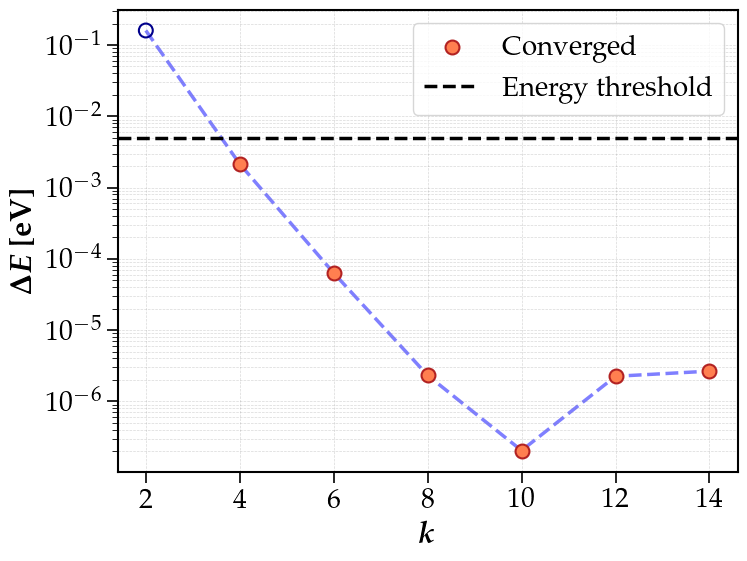

In [12]:
plt.plot(df["k"][:-1], df["Convergence"][:-1], linestyle="--", color="blue", alpha=0.5, zorder=1)
plt.scatter(df[~df["Converged"]]["k"], df[~df["Converged"]]["Convergence"],
            marker="o", color="None", edgecolor="darkblue", s=100, linewidths=1.5, zorder=2)
plt.scatter(df[df["Converged"]]["k"][:-1], df[df["Converged"]]["Convergence"][:-1], 
            marker="o", color="coral", edgecolors="firebrick", linewidths=1.5, label="Converged", zorder=2)
plt.axhline(energy_threshold, color='black', linestyle='--', label="Energy threshold")
plt.xlabel(r"$\boldsymbol{k}$")
plt.ylabel(r"$\boldsymbol{\Delta E}$ $\textbf{[eV]}$")
# plt.xscale("log")
plt.yscale("log")
plt.legend()

plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.3)

figname = "P3_energy_vs_k_points.pdf"
plt.savefig(os.path.join(FIG_PATH, figname), bbox_inches="tight")

plt.show()

#### Problem 4 (10 pts): Convergence of forces w.r.t the size of the $\vec k$ points mesh
- **Ca** atom displaced by +0.05 $\text{\AA}$ in the $z$ direction 
- $\vec k$ mesh with [2, 4, 6, 8, 10, 12, 14, 16]
- chosen value of $E_{\rm cut}=80$ Ry (converged value for both forces and total energy in problems 1 and 2)
- same force threshold as in Problem 2 (10 meV/$\text{\AA}$ )

In [13]:
force_filepath = "Problem4/simulations/forces.dat"
data = []
data.extend(extract_forces_k(force_filepath))
df = pd.DataFrame(data, columns=['k', 'Atom', 'Type', 'f_x', 'f_y', 'f_z [Ry/Bohr]'])\
        .sort_values(by=['k', 'Atom']).reset_index().drop(columns=['f_x', 'f_y', 'index']).astype({'k': int}) # drop f_x, f_y since they are always zero


In [14]:
df['f_z [eV/Ang]'] = df['f_z [Ry/Bohr]'] * Ry / Bohr
df_atom_1 = df[df["Atom"] == 1].copy()
df_atom_2 = df[df["Atom"] == 2].copy()

force_threshold = 10e-3 # eV/Angstrom
last_f_atom_1 = df_atom_1["f_z [eV/Ang]"].iloc[-1]
last_f_atom_2 = df_atom_2["f_z [eV/Ang]"].iloc[-1]
df_atom_1["Convergence"] = np.abs(df_atom_1["f_z [eV/Ang]"] - last_f_atom_1)
df_atom_2["Convergence"] = np.abs(df_atom_2["f_z [eV/Ang]"] - last_f_atom_2)
df_atom_1["Converged"] = df_atom_1["Convergence"] < force_threshold
df_atom_2["Converged"] = df_atom_2["Convergence"] < force_threshold

df_atom_1

,k,Atom,Type,f_z [Ry/Bohr],f_z [eV/Ang],Convergence,Converged
0,2,1,1,-0.016847,-0.433161,0.685076,False
2,4,1,1,-0.043135,-1.109053,0.009184,True
4,6,1,1,-0.043527,-1.119122,0.000884,True
6,8,1,1,-0.043533,-1.119272,0.001035,True
8,10,1,1,-0.043489,-1.118138,0.000099,True
10,12,1,1,-0.043497,-1.118362,0.000125,True
12,14,1,1,-0.043491,-1.118200,0.000038,True
14,16,1,1,-0.043493,-1.118237,0.000000,True


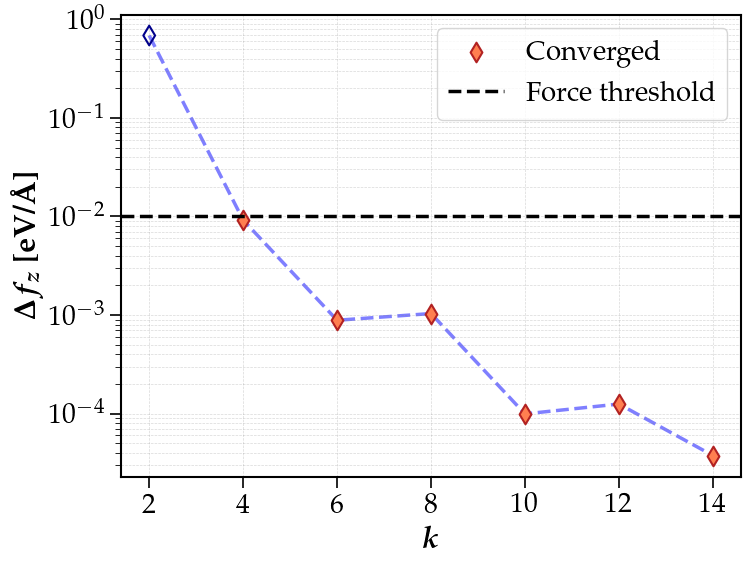

In [15]:
plt.plot(df_atom_1["k"][:-1], df_atom_1["Convergence"][:-1], linestyle="--", color="blue", alpha=0.5, zorder=1)
plt.scatter(df_atom_1[~df_atom_1["Converged"]]["k"], df_atom_1[~df_atom_1["Converged"]]["Convergence"], 
            marker="d", color="None", edgecolor="darkblue", s=100, linewidths=1.5, zorder=2)
plt.scatter(df_atom_1[df_atom_1["Converged"]]["k"][:-1], df_atom_1[df_atom_1["Converged"]]["Convergence"][:-1],
            marker="d", color="coral", edgecolors="firebrick", linewidths=1.5, label="Converged", zorder=2)
plt.axhline(force_threshold, color='black', linestyle='--', label="Force threshold")
plt.xlabel(r"$\boldsymbol{k}$")
plt.ylabel(r"$\boldsymbol{\Delta f_z}$ $\textbf{[eV/\AA]}$")
plt.legend()
plt.yscale('log')

plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.3)

figname = "P4_force_vs_k_points_atom_1.pdf"
plt.savefig(os.path.join(FIG_PATH, figname), bbox_inches="tight")

plt.show()

#### Problem 5 (5 pts): Convergence of total energy differences w.r.t energy cutoff
- Chosen $\vec k$ mesh: 6x6x6 (convergence of both forces and energies in Problem 3 and 4)
- Energy cutoffs: $[20, 30, 40, 50, 60, 70, 80, 90, 100, 1000]$ Ry, 1000 Ry being the reference for convergence.
- Threshold for energy difference: $5$ meV/atom

Energy computed for each cutoff with first $a=9a_0$ and then $a =9.05 a_0$ with $a_0$ the Bohr radius

In [16]:
print(f"Original lattice constant : {9*Bohr:.3f} Angstrom")
print(f"Second lattice constant : {9.05*Bohr:.3f} Angstrom")

Original lattice constant : 4.763 Angstrom
Second lattice constant : 4.789 Angstrom


In [17]:
filepath_1 = "Problem5/simulations/energies_a=9.00.dat"
filepath_2 = "Problem5/simulations_2/energies_a=9.05.dat"

df_1 = extract_energies(filepath_1)
df_2 = extract_energies(filepath_2)
df = merge_data(df_1, df_2)
display(df)

,E_cut [Ry],E [Ry]_a9.00,E [Ry]_a9.05,Delta E [Ry],E_cut [eV],Delta E [eV],Convergence
0,20,-54.470823,-54.473715,0.002893,272.113862,0.039355,False
1,30,-55.075566,-55.076686,0.001119,408.170794,0.015229,False
2,40,-55.292028,-55.292932,0.000904,544.227725,0.012299,False
3,50,-55.362798,-55.363370,0.000572,680.284656,0.007778,False
4,60,-55.382232,-55.382583,0.000351,816.341587,0.004774,True
5,70,-55.386145,-55.386532,0.000386,952.398519,0.005258,False
6,80,-55.386660,-55.387033,0.000373,1088.455450,0.005079,False
7,90,-55.386694,-55.387067,0.000374,1224.512381,0.005082,False
8,100,-55.386696,-55.387070,0.000374,1360.569312,0.005083,False
9,1000,-55.386717,-55.387090,0.000374,13605.693123,0.005082,False


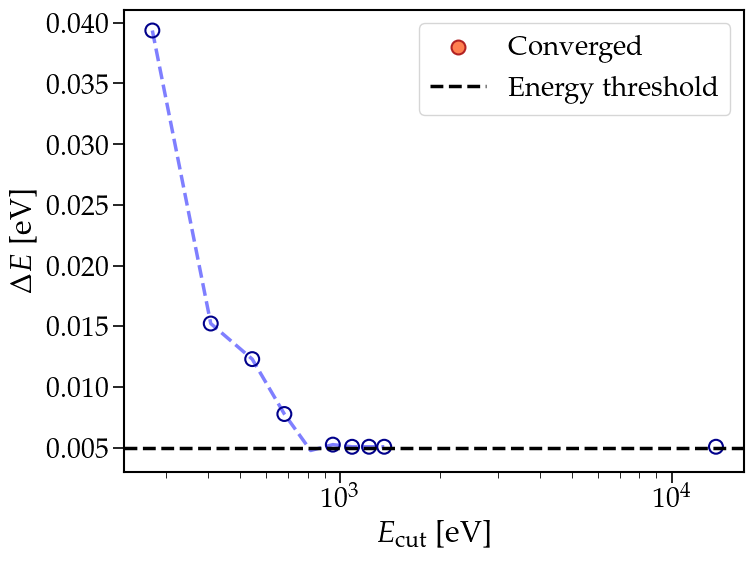

In [18]:
# Plotting the results
plt.plot(df["E_cut [eV]"][:-1], df["Delta E [eV]"][:-1], linestyle="--", color="blue", alpha=0.5, zorder=1)
plt.scatter(df[~df["Convergence"]]["E_cut [eV]"], df[~df["Convergence"]]["Delta E [eV]"], 
            marker="o", color="None", edgecolor="darkblue", s=100, linewidths=1.5, zorder=2)
plt.scatter(df[df["Convergence"]]["E_cut [eV]"][:-1], df[df["Convergence"]]["Delta E [eV]"][:-1],
            marker="o", color="coral", edgecolors="firebrick", linewidths=1.5, label="Converged", zorder=2)
plt.axhline(energy_threshold, color='black', linestyle='--', label="Energy threshold")
plt.xlabel(r"$E_{\rm cut}$ [eV]")
plt.ylabel(r"$\Delta E$ [eV]")
plt.legend()
plt.xscale("log")
plt.show()

In [19]:
# Second attempt with k=4
filepath_1 = "Problem5/simulations_k=4_a=9.00/energies.dat"
filepath_2 = "Problem5/simulations_k=4_a=9.05/energies.dat" 

df_1 = extract_energies(filepath_1)
df_2 = extract_energies(filepath_2)
df = merge_data(df_1, df_2)
display(df)

,E_cut [Ry],E [Ry]_a9.00,E [Ry]_a9.05,Delta E [Ry],E_cut [eV],Delta E [eV],Convergence
0,20,-54.466036,-54.475763,0.009728,272.113862,0.132350,False
1,30,-55.078958,-55.077567,0.001392,408.170794,0.018935,False
2,40,-55.291425,-55.292017,0.000592,544.227725,0.008057,False
3,50,-55.362740,-55.363315,0.000575,680.284656,0.007829,False
4,60,-55.382010,-55.382524,0.000514,816.341587,0.006989,False
5,70,-55.386002,-55.386365,0.000363,952.398519,0.004939,True
6,80,-55.386508,-55.386886,0.000379,1088.455450,0.005151,False
7,90,-55.386542,-55.386920,0.000378,1224.512381,0.005139,False
8,100,-55.386545,-55.386923,0.000378,1360.569312,0.005138,False
9,1000,-55.386565,-55.386943,0.000378,13605.693123,0.005137,False


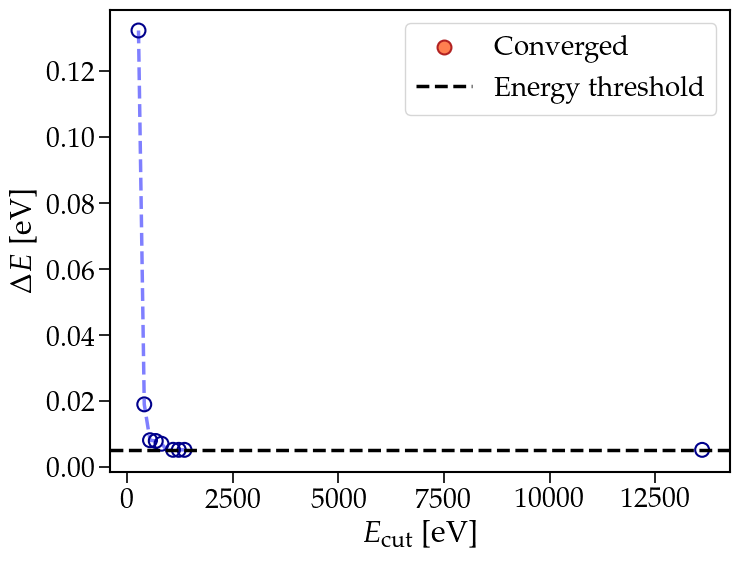

In [20]:
# Plotting the results
plt.plot(df["E_cut [eV]"][:-1], df["Delta E [eV]"][:-1], linestyle="--", color="blue", alpha=0.5, zorder=1)
plt.scatter(df[~df["Convergence"]]["E_cut [eV]"], df[~df["Convergence"]]["Delta E [eV]"],
            marker="o", color="None", edgecolor="darkblue", s=100, linewidths=1.5, zorder=2)
plt.scatter(df[df["Convergence"]]["E_cut [eV]"][:-1], df[df["Convergence"]]["Delta E [eV]"][:-1],
            marker="o", color="coral", edgecolors="firebrick", linewidths=1.5, label="Converged", zorder=2)
plt.axhline(energy_threshold, color='black', linestyle='--', label="Energy threshold")
plt.xlabel(r"$E_{\rm cut}$ [eV]")
plt.ylabel(r"$\Delta E$ [eV]")
plt.legend()
plt.show()

#### Problem 6 (10 pts): Discussion on problems 1 to 5

#### Problem 7 (5 pts): Determination of the equilibrium lattice parameter

Choice of parameters based on precedent problems: 
- $E_{cut}=70$ Ry
- $k$ grid of 4x4x4

Variation of lattice constants: 
- between $8a_0$ and $10a_0$ with stepsize of $0.05$
- additional simulations around the minima

In [21]:
filepath = "Problem7/simulations/energies.dat"
df = extract_energies_a_vary(filepath)
df.head()

,a [Bohr],E [Ry],E [eV],a [Ang],V [Ang^3]
0,8.00,-110.628502,-1505.177448,4.233418,18.967643
1,8.05,-110.643901,-1505.386967,4.259877,19.325514
2,8.10,-110.658155,-1505.580899,4.286335,19.687858
3,8.15,-110.671294,-1505.759669,4.312794,20.054703
4,8.20,-110.683392,-1505.924264,4.339253,20.426077


Optimal volume:  28.055203655793136 Ang^3
Optimal Lattice constant:  4.82345027410856 Ang


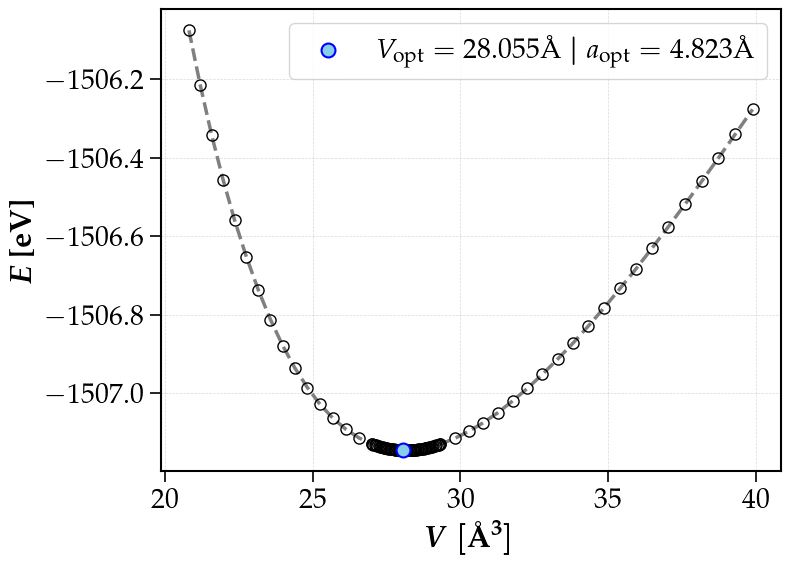

In [22]:
min_energy = df["E [eV]"].min()
min_energy_index = df["E [eV]"].idxmin()
optimal_volume = df["V [Ang^3]"].iloc[min_energy_index]
optimal_lattice_constant = df["a [Ang]"].iloc[min_energy_index]

print("Optimal volume: ", optimal_volume, "Ang^3")
print("Optimal Lattice constant: ", df["a [Ang]"].iloc[min_energy_index], "Ang")

V_min = 5
V_max = 15

plt.plot(df["V [Ang^3]"][V_min:-V_max], df["E [eV]"][V_min:-V_max], marker="o", color="grey", markerfacecolor="None", markersize=8, linestyle="--", markeredgecolor="black", zorder=1)
plt.scatter(optimal_volume, min_energy, marker="o", color="skyblue", label=rf"$V_{{\rm opt}} = {optimal_volume:.3f} {{\rm \AA}}  \;\boldsymbol{{\vert}}\; a_{{\rm opt}} = {optimal_lattice_constant:.3f} {{\rm \AA}}$",
            zorder=2, s=100, edgecolors="blue", linewidth=1.5)
plt.xlabel(r"$\boldsymbol{V \; [\rm \AA^3]}$")
plt.ylabel(r"$\boldsymbol{E}$ $\textbf{[eV]}$")
plt.grid(True, which="both", linestyle="--", alpha=0.3)
plt.legend()

figname = "P7_energy_vs_volume.pdf"
plt.savefig(os.path.join(FIG_PATH, figname), bbox_inches="tight")

plt.show()

# plt.plot(df["a [Ang]"][V_min:-V_max], df["E [eV]"][V_min:-V_max], marker="o", color="skyblue", markerfacecolor="None", markersize=8,linestyle="--", markeredgecolor="blue", zorder=1)
# plt.scatter(optimal_lattice_constant, min_energy, marker="o", color="skyblue", label=rf"Optimal lattice constant: {optimal_lattice_constant:.3f} $\rm \AA$",
#             zorder=2, s=90, edgecolors="black")
# plt.xlabel(r"$a \; [\rm \AA]$")
# plt.ylabel(r"$E$ [eV]")
# plt.grid(True, which="both", linestyle="--", alpha=0.5)
# plt.legend()
# plt.show()

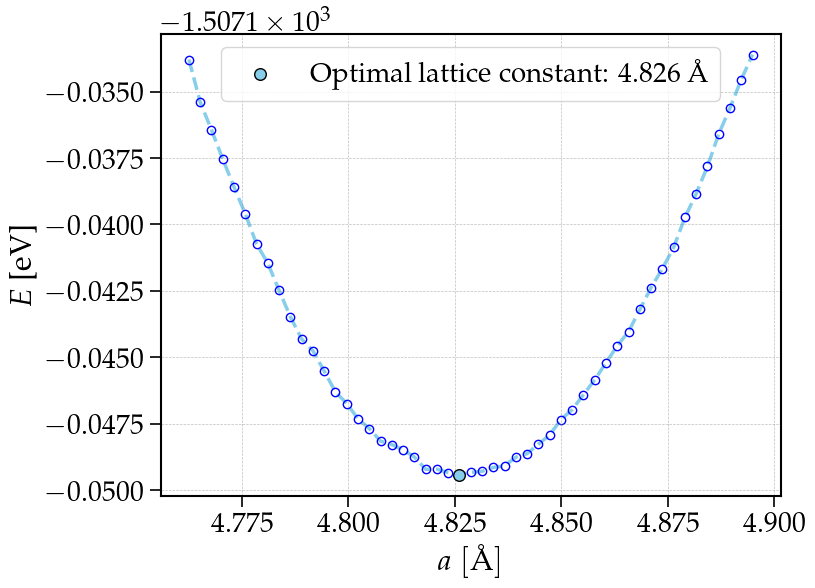

In [23]:
filepath = "Problem7/simulations_k=6/energies.dat"

df = extract_energies_a_vary(filepath)
min_energy = df["E [eV]"].min()
min_energy_index = df["E [eV]"].idxmin()
optimal_volume = df["V [Ang^3]"].iloc[min_energy_index]
optimal_lattice_constant = df["a [Ang]"].iloc[min_energy_index]

plt.plot(df["a [Ang]"], df["E [eV]"], marker="o", color="skyblue", markerfacecolor="None", markersize=6,linestyle="--", markeredgecolor="blue", zorder=1)
plt.scatter(optimal_lattice_constant, min_energy, marker="o", color="skyblue", label=rf"Optimal lattice constant: {optimal_lattice_constant:.3f} $\rm \AA$",
            zorder=2, s=70, edgecolors="black")
plt.xlabel(r"$a \; [\rm \AA]$")
plt.ylabel(r"$E$ [eV]")
plt.grid(True, which="both", linestyle="--", alpha=0.5)
plt.legend()
plt.show()

#### Problem 8 (20 pts): Determination of the bulk modulus

##### Part A: Derivation of the Bulk Modulus

##### Part B: Fit of the Birch Murnaghan equation of states

- Restrict to values of $a$ close to the optimal (as said in Lab1: a too small volume range can give inaccurate fit results because of numerical noise, while a too large volume range might not be well described by the eos). 

In [24]:
from scipy.optimize import curve_fit
from scipy.stats import t

In [25]:
filepath = "Problem7/simulations/energies.dat"
df = extract_energies_a_vary(filepath)
cond = (df["a [Ang]"] > 4.7) & (df["a [Ang]"] < 4.95)  
df = df[cond]

V_data = df["V [Ang^3]"].values
E_data = df["E [eV]"].values

print(f"Lattice constants range from {df['a [Ang]'].min():.3f} to {df['a [Ang]'].max():.3f} Angstrom")

Lattice constants range from 4.710 to 4.948 Angstrom


In [26]:
from lmfit import Model, conf_interval, report_ci

# Définition de votre fonction modèle, par exemple birch_murnaghan
model = Model(birch_murnaghan)
params = model.make_params(E0=E_data.min(), B0=1, B0_prime=4, V0=V_data.min())
result = model.fit(E_data, params, V=V_data)
print(result.fit_report())

sigma_levels = [1, 2, 3, 4]
ci = conf_interval(result, result, sigmas=sigma_levels)

print("## Confidence Report:")
report_ci(ci)

[[Model]]
    Model(birch_murnaghan)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 61
    # variables        = 4
    chi-square         = 3.1716e-06
    reduced chi-square = 5.5642e-08
    Akaike info crit   = -1015.10065
    Bayesian info crit = -1006.65715
    R-squared          = 0.99951542
[[Variables]]
    E0:       -1507.14547 +/- 3.8158e-05 (0.00%) (init = -1507.146)
    B0:        0.66195648 +/- 0.00194072 (0.29%) (init = 1)
    B0_prime:  3.89722971 +/- 0.18144384 (4.66%) (init = 4)
    V0:        28.1259080 +/- 0.00249999 (0.01%) (init = 26.11641)
[[Correlations]] (unreported correlations are < 0.100)
    C(B0_prime, V0) = -0.7810
    C(E0, B0)       = -0.6109
## Confidence Report:
             99.99%    99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%    99.99%
 E0      :  -0.00016  -0.00013  -0.00007  -0.00005-1507.14547  +0.00005  +0.00007  +0.00013  +0.00016
 B0      :  -0.00838  -0.00609  -0.003

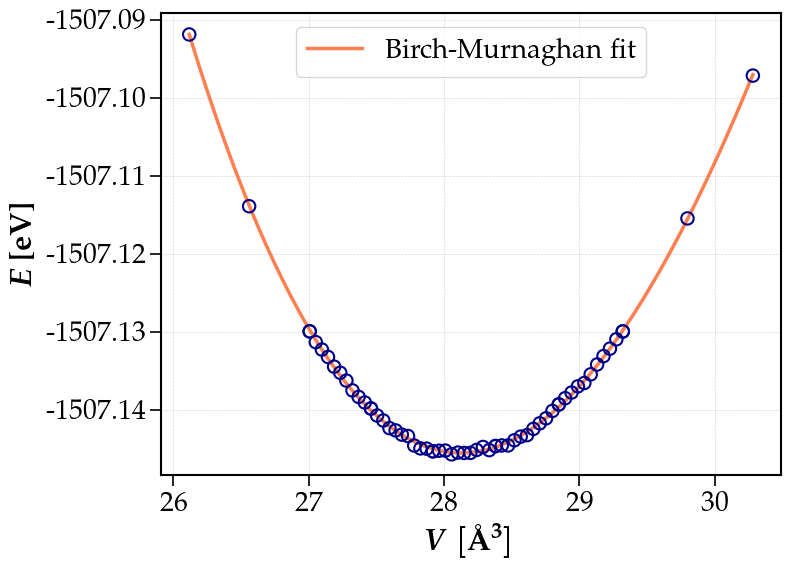

In [27]:
V_fit = np.linspace(V_data.min(), V_data.max(), 100)
E_fit = result.eval(V=V_fit)


import matplotlib.ticker as ticker
plt.scatter(V_data, E_data, marker="o", color="None", edgecolor="darkblue", s=80, linewidths=1.5, zorder=2)
plt.plot(V_fit, E_fit, color="coral", linestyle="-", label="Birch-Murnaghan fit", zorder=1)
plt.xlabel(r"$\boldsymbol{V \; [\rm \AA^3]}$")
plt.ylabel(r"$\boldsymbol{E}$ $\textbf{[eV]}$")
plt.grid(True, which="both", linestyle="--", alpha=0.3)
plt.legend()

plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
plt.ticklabel_format(axis='y', style='plain')
formatter = ticker.FormatStrFormatter('%.2f')
plt.gca().yaxis.set_major_formatter(formatter)

figname = "P8_birch_murnaghan_fit_V1.pdf"
plt.savefig(os.path.join(FIG_PATH, figname), bbox_inches="tight")

plt.show()

In [28]:
conversion_factor = eV / angstrom**3
B0 = result.params["B0"].value * conversion_factor * 1e-9  # Convert to GPa
ci_B0 = 0.00857 * conversion_factor * 1e-9  # GPa
standard_error = result.params["B0"].stderr * conversion_factor * 1e-9  # GPa

# Format bold printing for jupyter notebook
from IPython.display import display, HTML
display(HTML(fr"<b>95% confidence-interval B0: {B0:.1f} +/- {ci_B0:.1f} GPa</b>"))
display(HTML(f"<b>Standard error: B0 = {B0:.1f} +/- {standard_error:.1f} GPa</b>"))

#### Problem 9 (20 pts): $C_{11}$, $C_{12}$ and $C_{44}$ elastic constants of **CaO**

In [29]:
a_opt = 9.11
print(f"Optimal lattice parameter for the input file: {a_opt} Ry = {a_opt * Bohr:.3f} Angstrom")
print(f"Volume of the undistorted conventional cell: {a_opt**3} Ry^3 = {(a_opt*Bohr)**3:.3f} Angstrom^3")

Optimal lattice parameter for the input file: 9.11 Ry = 4.821 Angstrom
Volume of the undistorted conventional cell: 756.0580309999999 Ry^3 = 112.036 Angstrom^3


##### Finding $C_{11}$ and $C_{12}$ for a tetragonal strain

- Initial lattice vectors $A= (\vec a_1, \vec a_2, \vec a_3)^\top$
  - $\vec a_1 = a_{\rm opt}\vec e_x$
  - $\vec a_2 = a_{\rm opt}\vec e_y$
  - $\vec a_3 = a_{\rm opt}\vec e_z$
  
- After applying a tetragonal strain, lattice vectors change to $A' = A (\mathbb I + \varepsilon)$
  - $\vec a_1' = a_{\rm opt}(1+x)\vec e_x$
  - $\vec a_2' = a_{\rm opt}(1-x)\vec e_y$
  - $\vec a_3' = a_{\rm opt}(1+x^2/(1-x^2))\vec e_z$

- Simulations with 
  - energy cutoff: 70 Ry 
  - k mesh grid: 4x4x4
  - relaxation allowed

In [30]:
filepath = "Problem9/tetragonal_strain/strain_energies.dat"
df = parse_energy_file(filepath)
x, delta_E = compute_Delta_E(df)

In [31]:
polynomial = Model(second_order_polynomial)
params = polynomial.make_params(a=0.1, b=0, c=0)
result = polynomial.fit(delta_E, params, x=x)
print(result.fit_report())
sigma_levels = [1, 2, 3, 4]
ci = conf_interval(result, result, sigmas=sigma_levels)
print("## Confidence Report:")
report_ci(ci)

[[Model]]
    Model(second_order_polynomial)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 21
    # variables        = 3
    chi-square         = 0.00512225
    reduced chi-square = 2.8457e-04
    Akaike info crit   = -168.692379
    Bayesian info crit = -165.558812
    R-squared          = 0.99839301
[[Variables]]
    a:  119.106200 +/- 1.12629857 (0.95%) (init = 0.1)
    b:  8.6716e-08 +/- 0.06077000 (70079384.38%) (init = 0)
    c: -0.01695897 +/- 0.00553225 (32.62%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, c) = -0.7465


c:\Users\celin\anaconda3\envs\mse468\lib\site-packages\lmfit\confidence.py:362: UserWarning: maxiter=200 reached and prob(b=-0.2009999132840513) = 0.9960740128923651 < max(sigmas)
  warn(errmsg)


## Confidence Report:
      99.99%    99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%    99.99%
 a:  -5.83129  -3.91449  -2.42025  -1.15847 119.10620  +1.15847  +2.42025  +3.91449  +5.83129
 b:      -inf      -inf  -0.13063  -0.06253   0.00000  +0.06253  +0.13063      +inf      +inf
 c:  -0.02864  -0.01923  -0.01189  -0.00569  -0.01696  +0.00569  +0.01189  +0.01923  +0.02864


c:\Users\celin\anaconda3\envs\mse468\lib\site-packages\lmfit\confidence.py:362: UserWarning: maxiter=200 reached and prob(b=0.201000086715949) = 0.9960740376211048 < max(sigmas)
  warn(errmsg)


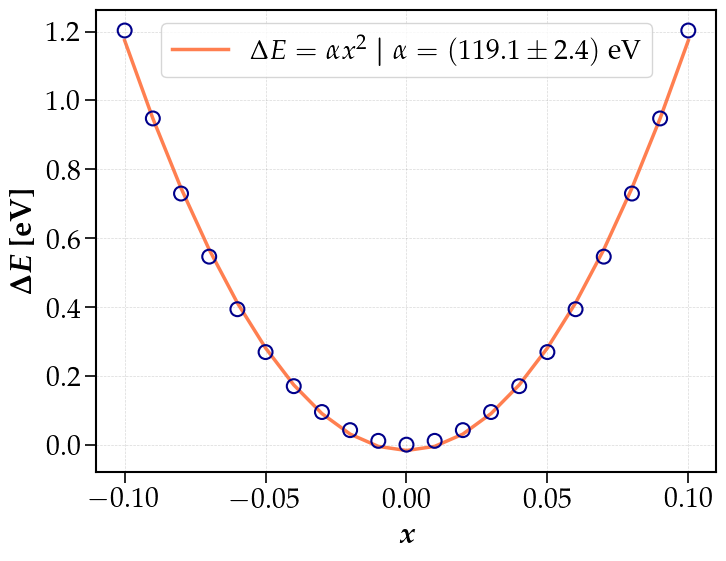

In [32]:
alpha = result.params["a"].value
ci_alpha = 2.42025

# Plot the data and the fit
plt.figure(figsize=(8, 6))
plt.plot(x, result.best_fit, color='coral', zorder=1, label=rf"$\Delta E = \alpha x^2 \;\boldsymbol{{\vert}}\;\alpha = ({alpha:.1f} \pm {ci_alpha:.1f})$ eV")
plt.scatter(x, delta_E, marker="o", color="None", edgecolor="darkblue", s=100, linewidths=1.5, zorder=2)
plt.xlabel(r'$\boldsymbol{x}$')
plt.ylabel(r'$\boldsymbol{\Delta E}$ $\textbf{[eV]}$')
plt.grid(True, which='both', linestyle='--', alpha=0.3)
plt.legend()

figname = "P9_tetragonal_strain_C11_C12.pdf"
plt.savefig(os.path.join(FIG_PATH, figname), bbox_inches="tight")

plt.show()

$$B = \frac{1}{3}(C_{11} + C_{12})$$ 
and 
$$\Delta E(x) = \alpha x^2 = V_0(C_{11}-C_{12})x^2$$

Therefore, 
$$ C_{11} = B + \frac{2}{3}\frac{\alpha}{V_0} \quad \text{and} \quad C_{12} = B - \frac{1}{3}\frac{\alpha}{V_0}$$

Error for $C_{11}$: 
$$\Delta C_{11} = \frac{\partial C_{11}}{\partial B}\Delta B + \frac{\partial C_{11}}{\partial \alpha}\Delta \alpha + \frac{\partial C_{11}}{\partial V_0}\Delta V_0 = \Delta B + \frac{2}{3}\left(\frac{\Delta \alpha}{V_0}+\frac{\alpha\Delta V_0}{V_0^2}\right)$$

Error for $C_{12}$ 
$$\Delta C_{12} = \Delta B + \frac{1}{3}\left(\frac{\Delta \alpha}{V_0}+\frac{\alpha\Delta V_0}{V_0^2}\right)$$

In [33]:
V_0 = (a_opt * Bohr)**3 

C11 = B0 + 2 * alpha / (3 * V_0) 
C12 = B0 - alpha/(3 * V_0)

# Compute errors for C11 and C12
error_V0 = V_0 * 0.005  
error_B0 = ci_B0
error_alpha = ci_alpha

C11_error = error_B0 + (2/3) * (error_alpha/V_0 + alpha * error_V0 / V_0**2)
C12_error = error_B0 + (1/3) * (error_alpha/V_0 + alpha * error_V0 / V_0**2) 

print(f"C11 = ({C11:.5f} +/- {C11_error:.5f}) GPa")
print(f"C12 = ({C12:.5f} +/- {C12_error:.5f}) GPa")

C11 = (106.76586 +/- 1.39101) GPa
C12 = (105.70275 +/- 1.38204) GPa


##### Finding $C_{44}$ for another tetragonal strain

In [34]:
filepath = "Problem9/tetragonal_strain_c44/strain_energies.dat"
df = parse_energy_file(filepath)
x, delta_E = compute_Delta_E(df)

polynomial = Model(second_order_polynomial)
params = polynomial.make_params(a=0.1, b=0, c=0)
result = polynomial.fit(delta_E, params, x=x)
print(result.fit_report())
sigma_levels = [1, 2, 3, 4]
ci = conf_interval(result, result, sigmas=sigma_levels)
print("## Confidence Report:")
report_ci(ci)

[[Model]]
    Model(second_order_polynomial)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 21
    # variables        = 3
    chi-square         = 2.3621e-06
    reduced chi-square = 1.3123e-07
    Akaike info crit   = -330.009910
    Bayesian info crit = -326.876343
    R-squared          = 0.99998546
[[Variables]]
    a:  26.9138892 +/- 0.02418659 (0.09%) (init = 0.1)
    b: -4.9462e-10 +/- 0.00130503 (263845533.43%) (init = 0)
    c:  2.7107e-04 +/- 1.1880e-04 (43.83%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, c) = -0.7465
## Confidence Report:
      99.99%    99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%    99.99%
 a:  -0.12526  -0.08406  -0.05199  -0.02489  26.91389  +0.02489  +0.05199  +0.08406  +0.12526
 b:  -0.00676  -0.00454  -0.00281  -0.00134  -0.00000  +0.00134  +0.00281  +0.00454  +0.00676
 c:  -0.00062  -0.00041  -0.00026  -0.00012   0.00027  +0.00012  +0.00026 

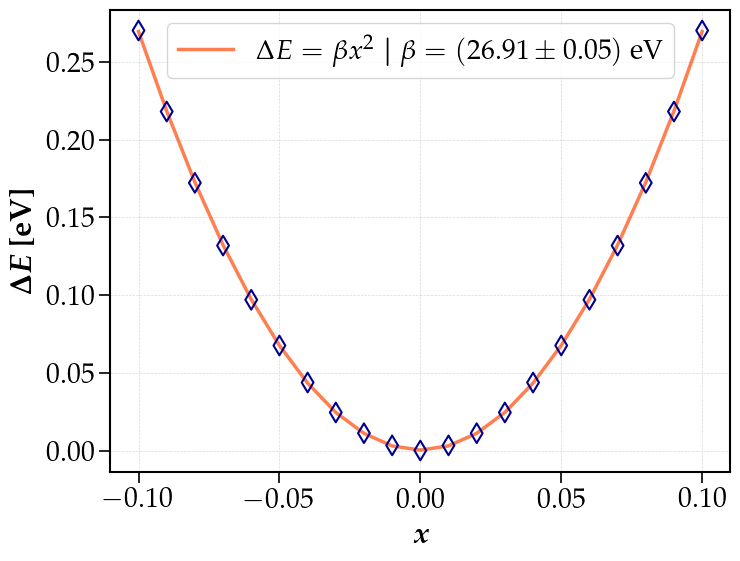

In [35]:
beta = result.params["a"].value
beta_error = 0.05199

# Plot the data and the fit
plt.figure(figsize=(8, 6))
plt.scatter(x, delta_E, marker="d", color="None", edgecolor="darkblue", s=100, linewidths=1.5, zorder=2)
plt.plot(x, result.best_fit, color='coral', zorder=1, label=rf"$\Delta E = \beta x^2 \;\boldsymbol{{\vert}}\;\beta= ({beta:.2f} \pm {beta_error:.2f})$ eV")
plt.xlabel(r'$\boldsymbol{x}$')
plt.ylabel(r'$\boldsymbol{\Delta E}$ $\textbf{[eV]}$')
plt.grid(True, which='both', linestyle='--', alpha=0.3)
plt.legend()

figname = "P9_tetragonal_strain_C44.pdf"
plt.savefig(os.path.join(FIG_PATH, figname), bbox_inches="tight")

plt.show()

Here $$\Delta E(x) = \beta x^2 = \frac{1}{2}V_0 C_{44}x^2$$ therefore, 
$$C_{44} = 2\frac{\beta}{V_0} $$
and 
$$\Delta C_{44} = 2\left(\frac{\Delta \beta}{V_0} + \frac{\beta \Delta V_0}{V_0^2}\right)$$

In [36]:
C44 = 2*beta/V_0 # eV / Angstrom^3
C_44_error = (2/V_0) * (beta_error + beta * error_V0 / V_0) # eV / Angstrom^3
C44_GPa = C44 * conversion_factor * 1e-9 # GPa
C_44_error_GPa = C_44_error * conversion_factor * 1e-9 # GPa

print(f"C44 = ({C44:.5f} +/- {C_44_error:.5f}) eV / Angstrom^3")
print(f"C44 = ({C44_GPa:.5f} +/- {C_44_error_GPa:.5f}) GPa")

C44 = (0.48045 +/- 0.00333) eV / Angstrom^3
C44 = (76.97653 +/- 0.53358) GPa
